## OVERVIEW

In this application, I explored a dataset from kaggle.
The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing. My goal was to understand what factors make a car more or less expensive. As a result of my analysis provide clear recommendations to a client -- a used car dealership -- as to what consumers value in a used car.

In [150]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Normalizer, PowerTransformer,FunctionTransformer


from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
# Set display option to show full numeric values (suppress scientific notation)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Business Understanding
From a business perspective, we are tasked with identifying key drivers for used car prices.
- Based on 

### Load Data

In [3]:
# import data
data = pd.read_csv('data/vehicles.csv')

In [4]:
# DataFrame Shape
print(f'DataFrame shape: {data.shape}\n')

# Data Types
data.info()

DataFrame shape: (426880, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426

##### Datraframe has the following columns
- id: A unique identifier for each listing.
- region: The geographical region of the listing.
- price: The listed price of the vehicle. (y feature)
- year: The manufacturing year of the vehicle.
- manufacturer: The manufacturer of the vehicle.
- model: The model of the vehicle.
- condition: The condition of the vehicle.
- cylinders: Information about the vehicle's engine cylinders.
- fuel: The type of fuel the vehicle uses.
- odometer: The vehicle's odometer reading.
- title_status: The status of the vehicle's title.
- transmission: The type of transmission in the vehicle.
- VIN: The Vehicle Identification Number.
- drive: The drive type of the vehicle (e.g., front-wheel, rear-wheel).
- size: The size of the vehicle.
- type: The type of vehicle (e.g., SUV, sedan).
- paint_color: The color of the vehicle.
- state: The state where the vehicle is listed.

In [5]:
# Sample data
data.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
342008,7315277145,rhode island,3450,2005.000,nissan,murano sl,good,6 cylinders,gas,161000.000,clean,automatic,NaN,4wd,mid-size,SUV,grey,ri
326859,7311151588,salem,0,2013.000,ram,1500,NaN,8 cylinders,gas,107974.000,clean,automatic,1C6RR7MTXDS708610,4wd,NaN,truck,NaN,or
75136,7303406534,colorado springs,19995,2014.000,jeep,grand cherokee,NaN,NaN,gas,89189.000,clean,automatic,1C4RJFCG5EC233328,4wd,NaN,SUV,NaN,co
329826,7304234899,harrisburg,16995,2016.000,toyota,camry hybrid xle,excellent,4 cylinders,hybrid,86000.000,clean,automatic,NaN,fwd,mid-size,sedan,silver,pa
399507,7313037377,winchester,17780,2011.000,gmc,sierra 1500,like new,8 cylinders,gas,112163.000,clean,automatic,3GTP1VE06BG324960,NaN,full-size,pickup,blue,va


### Data Understanding (Exploratory Data Analysis)

After considering the business understanding, let's get familiar with the data.

#### Missing data

In [6]:
# Calculate the percentage of missing data for each column
missing_data_percentage = data.isnull().mean() * 100

# Print the percentage of missing data
print(missing_data_percentage.sort_values(ascending=False))

size           71.767
cylinders      41.622
condition      40.785
VIN            37.725
drive          30.586
paint_color    30.501
type           21.753
manufacturer    4.134
title_status    1.931
model           1.236
odometer        1.031
fuel            0.706
transmission    0.599
year            0.282
region          0.000
id              0.000
price           0.000
state           0.000
dtype: float64


In [7]:
# Count the number of unique values in each column
unique_data_percentage = data.nunique()

# Print the count of unique values
print(unique_data_percentage)

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64


#### Price analysis

In [8]:
data['price'].describe()

count       426880.000
mean         75199.033
std       12182282.174
min              0.000
25%           5900.000
50%          13950.000
75%          26485.750
max     3736928711.000
Name: price, dtype: float64

In [177]:
# Top 60 most expensive cars
data.sort_values(by='price', ascending=False).head(60)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.000,toyota,tundra,excellent,8 cylinders,gas,164000.000,clean,automatic,NaN,4wd,full-size,pickup,silver,or
356716,7302445002,knoxville,3736928711,1999.000,toyota,4runner,fair,6 cylinders,gas,211000.000,clean,automatic,NaN,4wd,mid-size,NaN,green,tn
91576,7309730903,delaware,3024942282,2000.000,mercedes-benz,benz e320,NaN,NaN,gas,100000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,de
257840,7309735768,south jersey,3024942282,2000.000,mercedes-benz,benz s430,NaN,NaN,gas,100000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
37410,7314052904,modesto,3009548743,2021.000,chevrolet,NaN,NaN,8 cylinders,gas,1000.000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
184704,7304345156,frederick,1410065407,1989.000,jeep,wrangler,NaN,NaN,diesel,103000.000,clean,manual,NaN,NaN,NaN,SUV,NaN,md
153082,7305153975,indianapolis,1234567890,2006.000,volvo,vnl,fair,NaN,other,200000.000,clean,manual,NaN,NaN,NaN,NaN,black,in
37409,7314053169,modesto,1111111111,2020.000,jeep,NaN,NaN,NaN,gas,1000.000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
29386,7305265540,humboldt county,1111111111,1999.000,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.000,clean,automatic,NaN,rwd,full-size,pickup,white,ca
122470,7315836487,atlanta,987654321,1960.000,chevrolet,NaN,NaN,NaN,gas,9999999.000,clean,manual,NaN,NaN,NaN,NaN,NaN,ga


In [12]:
# Top 10 cheapest cars - price >0
data.query('price > 0 ').sort_values(by='price', ascending=True).head(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
335449,7316980503,pittsburgh,1,2001.000,gmc,NaN,like new,8 cylinders,gas,120.000,clean,automatic,NaN,rwd,NaN,NaN,NaN,pa
379134,7305722046,mcallen / edinburg,1,2014.000,chevrolet,camaro,NaN,6 cylinders,gas,108000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,tx
248884,7312828120,las vegas,1,1963.000,pontiac,lemans,NaN,NaN,gas,88844.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,nv
379086,7306587509,mcallen / edinburg,1,2011.000,ford,fusion,excellent,4 cylinders,gas,138000.000,clean,automatic,NaN,fwd,mid-size,sedan,silver,tx
379098,7306397461,mcallen / edinburg,1,2017.000,ford,fusion,NaN,NaN,gas,105000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,tx
105168,7315012721,orlando,1,2010.000,NaN,-,excellent,6 cylinders,gas,0.000,clean,automatic,2C4RDGBG7HR829969,fwd,NaN,NaN,NaN,fl
377548,7316051576,laredo,1,2013.000,toyota,camry,NaN,NaN,gas,89000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,tx
101232,7311387217,lakeland,1,2014.000,ford,f-150,excellent,8 cylinders,gas,113589.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl
209111,7307963825,saginaw-midland-baycity,1,1998.000,bmw,740il,good,8 cylinders,gas,67250.000,clean,automatic,NaN,rwd,full-size,NaN,green,mi
379129,7305873163,mcallen / edinburg,1,2008.000,ford,f250 king ranch,NaN,NaN,diesel,173000.000,clean,automatic,NaN,NaN,NaN,NaN,NaN,tx


[]

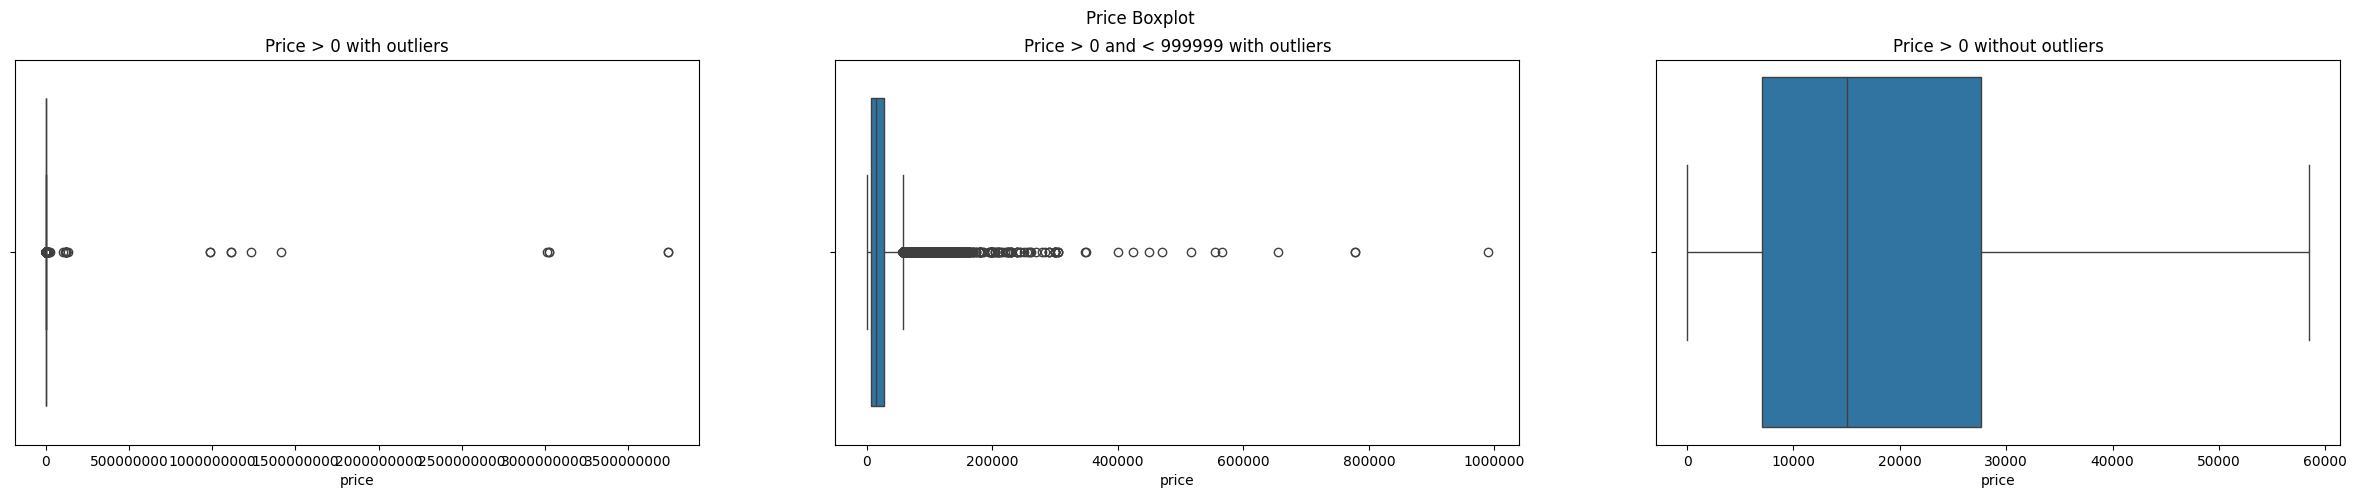

In [13]:
# Price distribution
fig, axes = plt.subplots(1,3,figsize=(30,5))

plt.suptitle(f'Price Boxplot')

sns.boxplot(x=data.query('price > 0')['price'],ax=axes[0])
axes[0].set_title('Price > 0 with outliers')
axes[0].ticklabel_format(style='plain', axis='x')

sns.boxplot(x=data.query('price > 0 and price < 999999')['price'],ax=axes[1])
axes[1].set_title('Price > 0 and < 999999 with outliers')
axes[1].ticklabel_format(style='plain', axis='x')

sns.boxplot(x=data.query('price > 0')['price'],ax=axes[2],showfliers = False)
axes[2].set_title('Price > 0 without outliers')
axes[2].ticklabel_format(style='plain', axis='x')    
    
plt.plot()

In [14]:
# Number of outliers
print('Number of outliers\n')

a = 0
b = 0
for i in range(99,1000,100):
    n = data.query('price >= (@i-100) and price < @i').shape[0]
    print(f'Number of cars where price is >= {i-100} and price < {i}: {n}')
    a += n

print('\n')
print(f'Number of cars where price is < 999: {data.query("price >= 0 and price < 999").shape[0]}')

b = data.query("price > 600000").shape[0]
print(f'Number of cars where price is > 60k: {b}')

print(f'Total number of outliers: {a+b}')

Number of outliers

Number of cars where price is >= -1 and price < 99: 35407
Number of cars where price is >= 99 and price < 199: 2033
Number of cars where price is >= 199 and price < 299: 1825
Number of cars where price is >= 299 and price < 399: 1529
Number of cars where price is >= 399 and price < 499: 1186
Number of cars where price is >= 499 and price < 599: 1789
Number of cars where price is >= 599 and price < 699: 572
Number of cars where price is >= 699 and price < 799: 649
Number of cars where price is >= 799 and price < 899: 673
Number of cars where price is >= 899 and price < 999: 476


Number of cars where price is < 999: 46139
Number of cars where price is > 60k: 65
Total number of outliers: 46204


#### Price Analysis

Clearly there are many data inconsistencies between cars with very high values. The models/manufacturers are not consistent with the prices in the Dataset. For this reason, I will limit the review to cars priced under US$600k.

There are also many data inconsistencies between cars with very low values. The models/manufacturers are not consistent with the prices in the Dataset. For this reason, I will limit the review to cars priced above US$999.

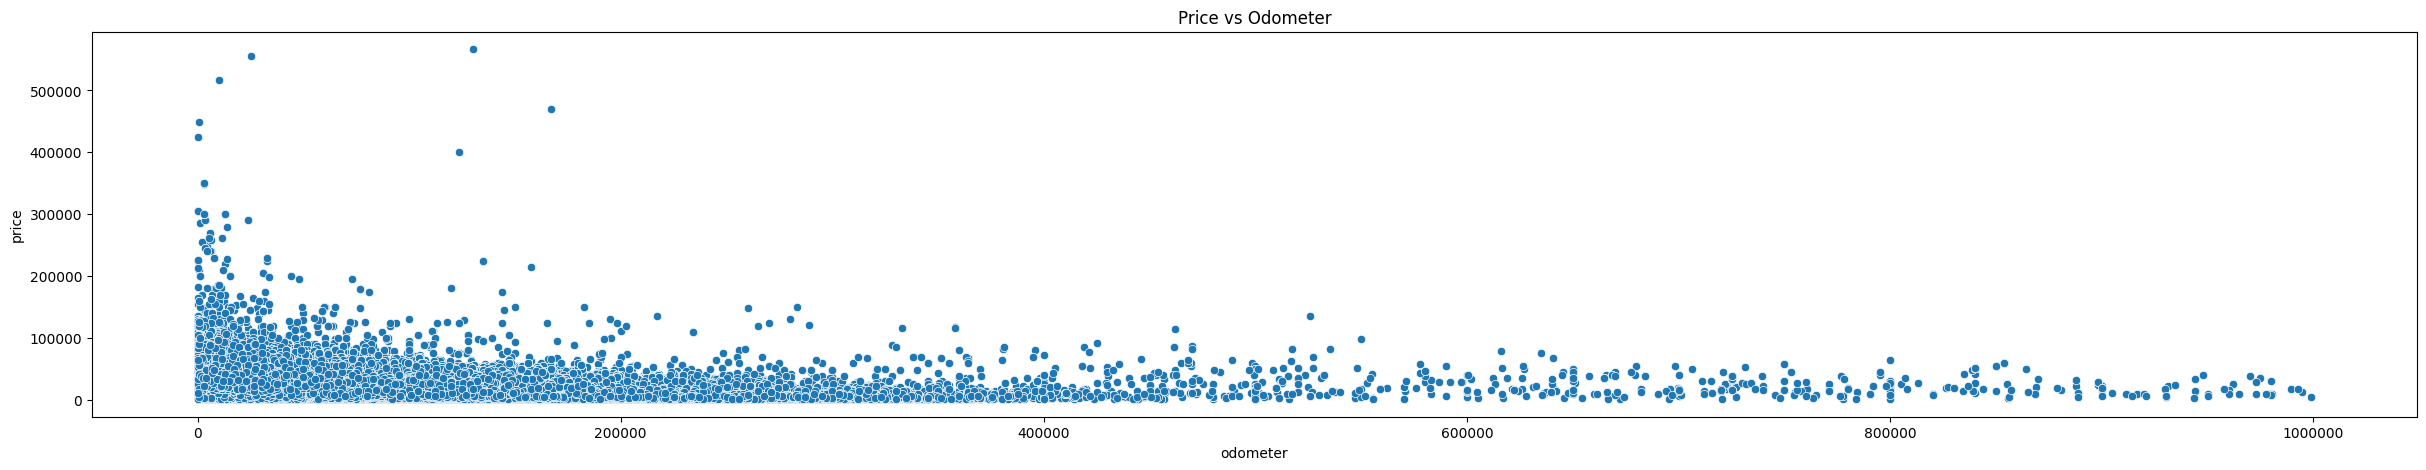

In [15]:
# Scatterplot Price and Odometer
plt.figure(figsize=(30,5))
plt.title('Price vs Odometer')
sns.scatterplot(y=data.query('price > 999 and price < 600000 and odometer < 999999')['price']\
                ,x=data.query('price > 999 and price < 600000 and odometer < 999999')['odometer'])
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

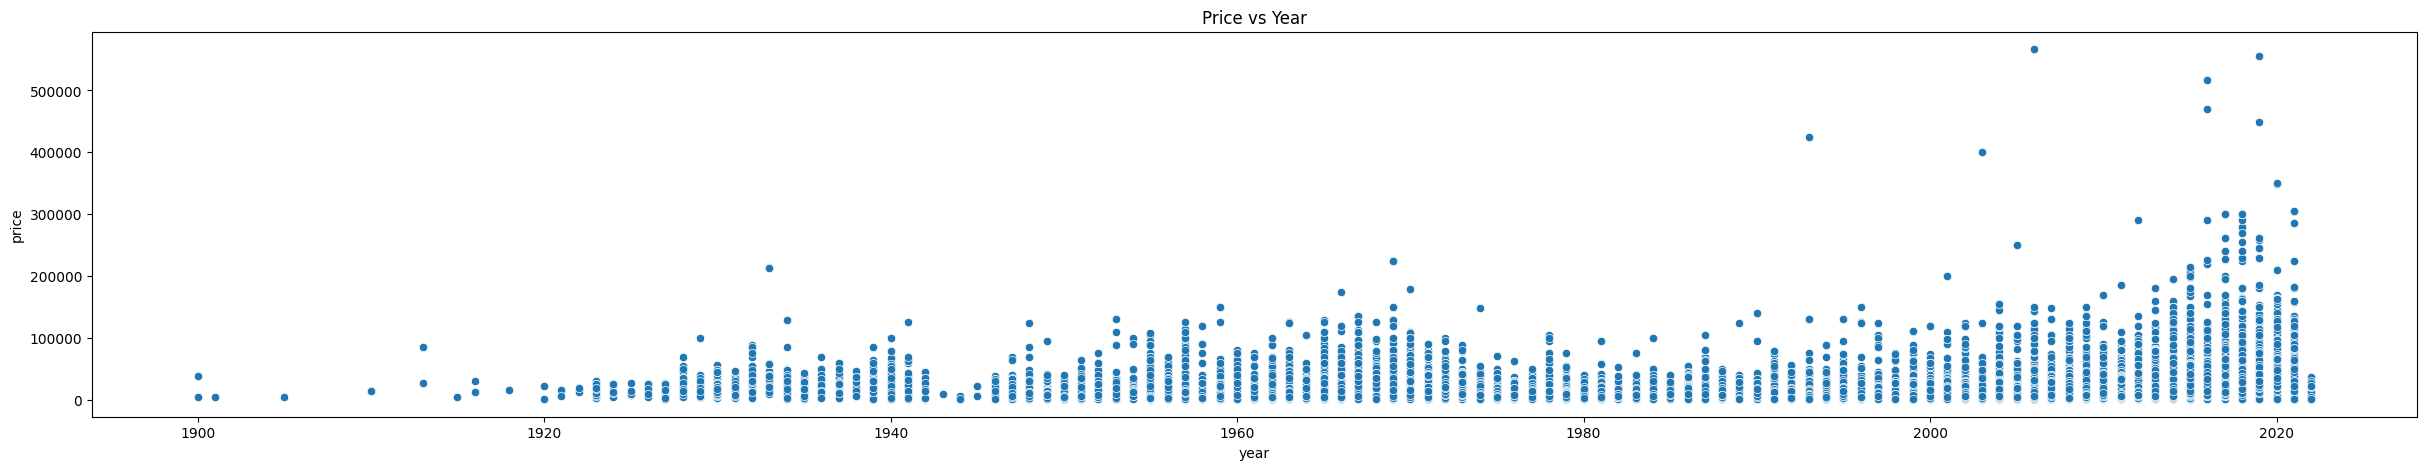

In [16]:
# Scatterplot Price and Year
plt.figure(figsize=(30,5))
plt.title('Price vs Year')
sns.scatterplot(y=data.query('price > 999 and price < 600000')['price']\
                ,x=data.query('price > 999 and price < 600000')['year'])
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

/Users/g.dornella/Documents/code/car-price/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


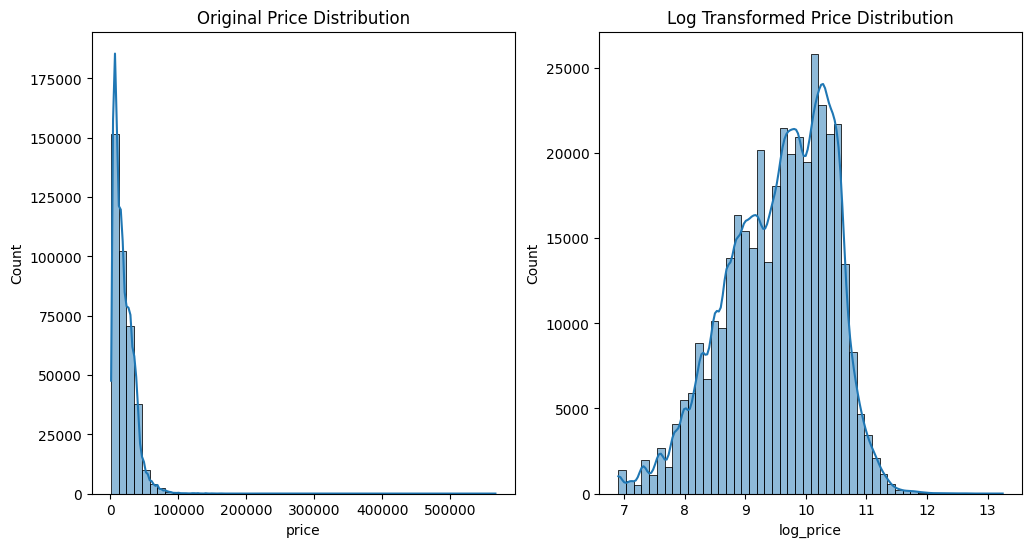

In [17]:
# Considering 'price' is right skewed, I transformed the price using log.
data1 = data[(data['price'] < 600000) & (data['price'] > 999)].copy()
data1['log_price'] = np.log(data['price'])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data1['price'], bins=50, kde=True)
plt.title('Original Price Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data1['log_price'], bins=50, kde=True)
plt.title('Log Transformed Price Distribution')

plt.show()



In [18]:
skewness = data1['log_price'].skew()
print("Skewness of Log Transformed Prices:", skewness)

Skewness of Log Transformed Prices: -0.47314449720403273


In [19]:
data[(data['price'] < 600000) & (data['price'] > 999)]['price'].describe()

count   380500.000
mean     19560.349
std      15332.461
min       1000.000
25%       7990.000
50%      15990.000
75%      27990.000
max     566567.000
Name: price, dtype: float64

In [20]:
baseline_mean = data[(data['price'] < 999999) & (data['price'] > 999)]['price'].mean()
baseline_mean

19568.554388390134

### Average price by region, state, year, transmission, odometer, fuel, model, title_status, manufacturer

In [21]:
# function to plot the average price of a feature
def plot_avg_price_feature(df, feature):

    # calulate the avereage price by feature
    avg_price_region = data1.groupby(feature).agg({'price':'mean','id':pd.Series.nunique}).reset_index().sort_values(by='price',ascending=False)

    # calculate the avearage quantity by feature
    avg_quantity_feature = (df[feature].value_counts(normalize=True,ascending=False)*100).mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(30,5))

    plt.suptitle(f'Average price by {feature}')
    
    sns.barplot(data=avg_price_region, x=feature, y='price',ax=axes[0])
    axes[0].tick_params(labelrotation=90)
    axes[0].ticklabel_format(style='plain', axis='y')
    axes[0].axhline(baseline_mean, color='r')

    sns.countplot(data=df, x=feature, ax=axes[1], order=df[feature].value_counts(ascending=False).index, stat='percent')
    axes[1].tick_params(labelrotation=90)
    axes[1].ticklabel_format(style='plain', axis='y')
    axes[1].axhline(avg_quantity_feature, color='r') 
    
    plt.plot()

In [22]:
def plot_box_price_feature(df,feature):

    
    fig, axes = plt.subplots(1,2,figsize=(30,5))

    sns.boxplot(x=df[feature],y=df['price'],ax=axes[0])
    axes[0].tick_params(labelrotation=90)
    axes[0].ticklabel_format(style='plain', axis='y')
    axes[0].set_title('With outliers')
    
    sns.boxplot(x=df[feature],y=df['price'],showfliers = False, ax=axes[1])
    axes[1].tick_params(labelrotation=90)
    axes[1].ticklabel_format(style='plain', axis='y')
    axes[1].set_title('Without outliers')
    
    plt.suptitle(f'Price Boxplot by {feature}')
    
    plt.plot()

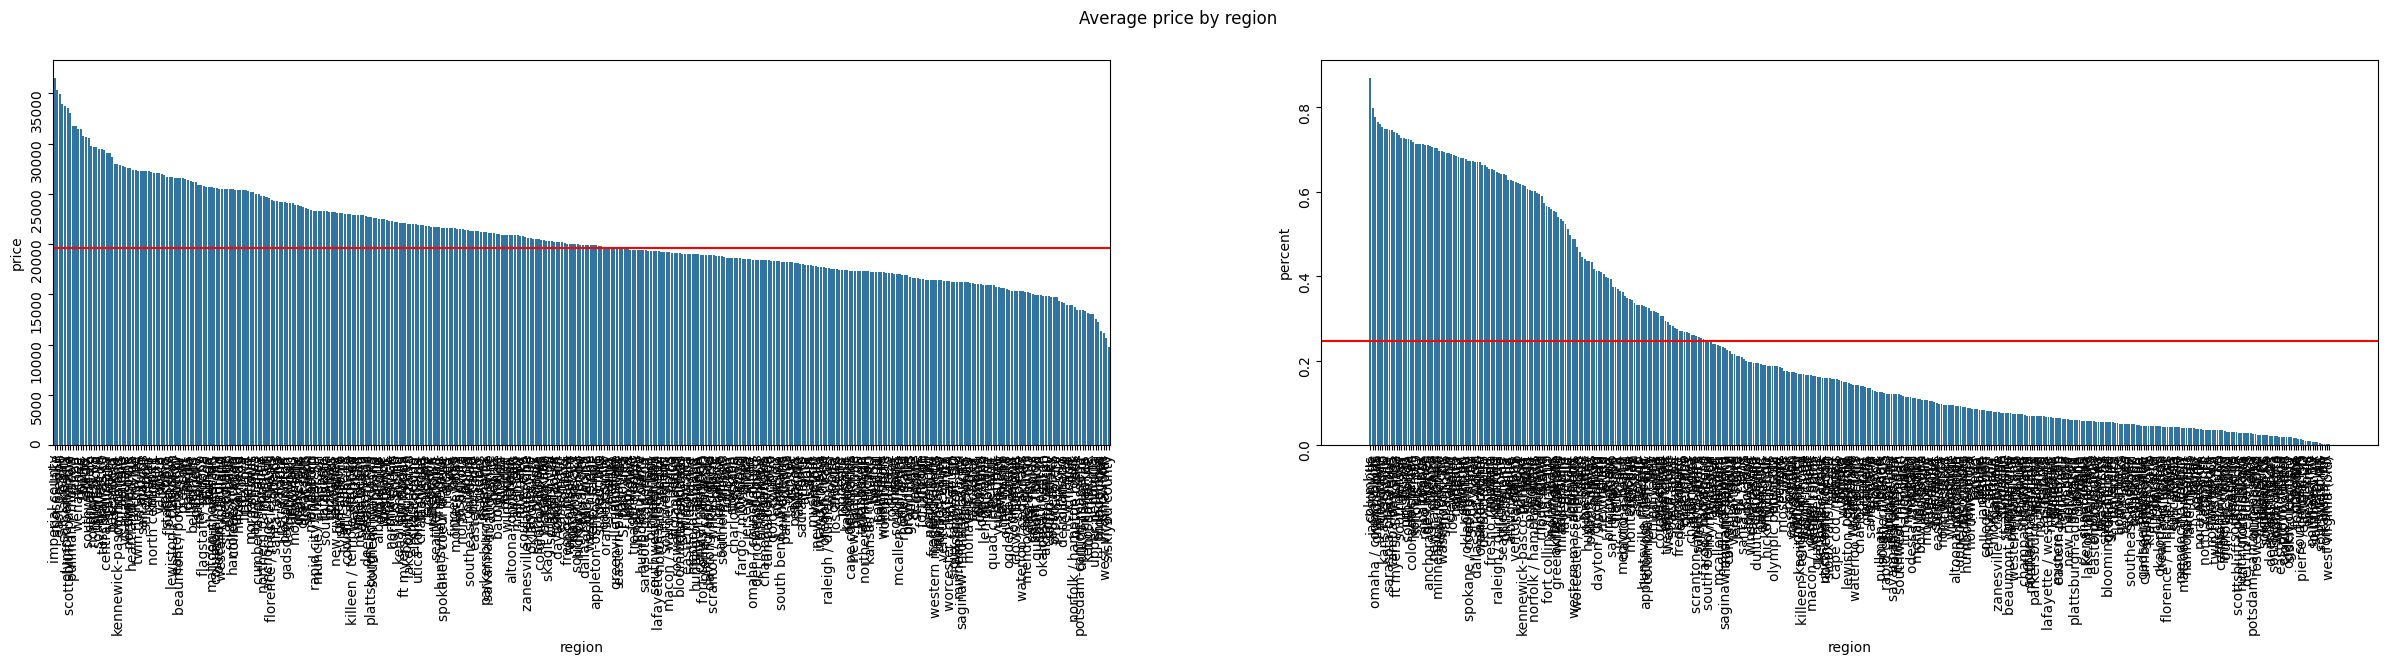

In [23]:
# by region
plot_avg_price_feature(data1,'region')

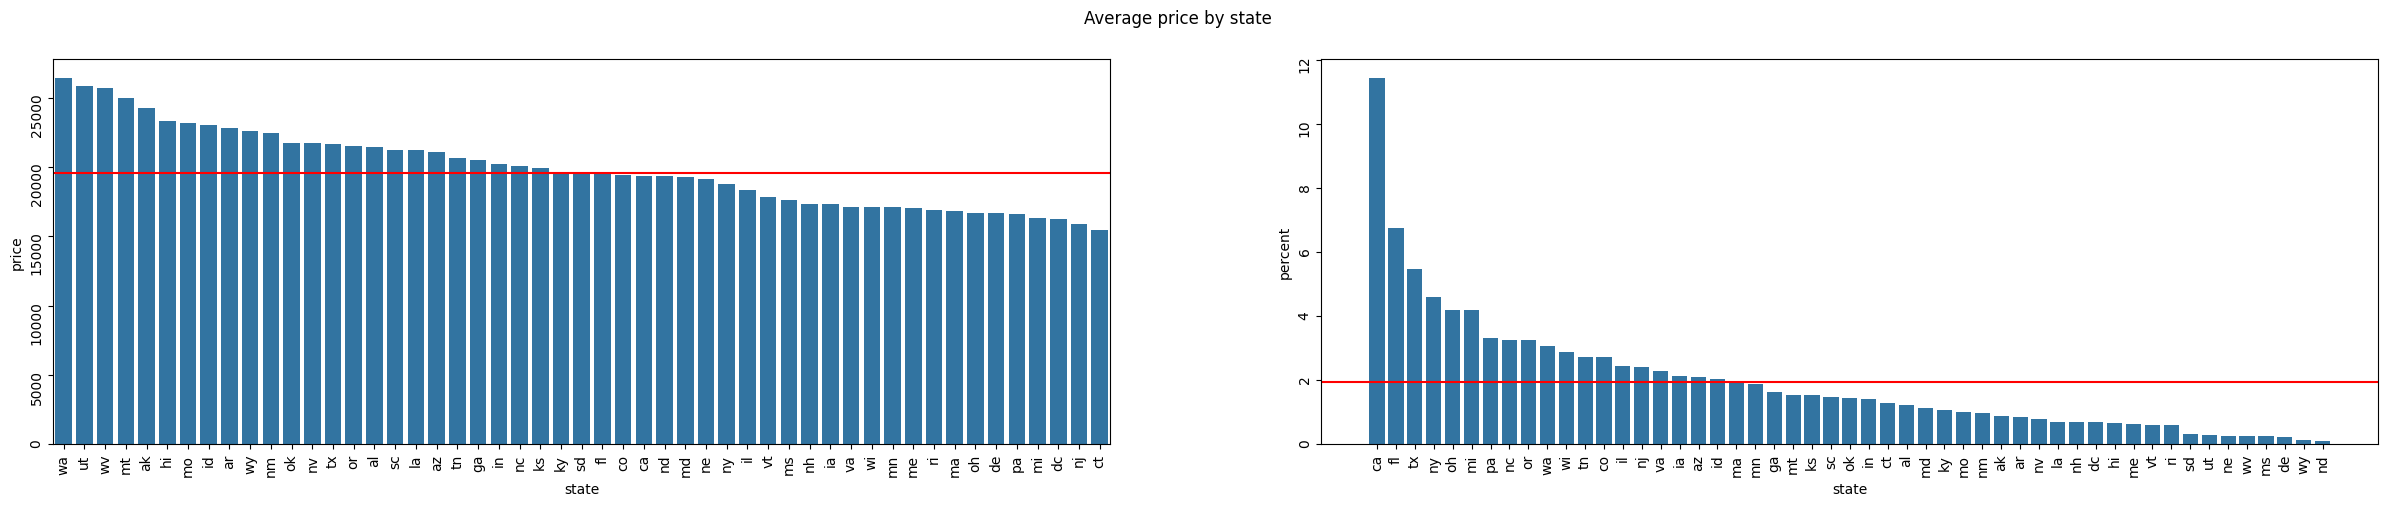

In [24]:
# by state
plot_avg_price_feature(data1,'state')

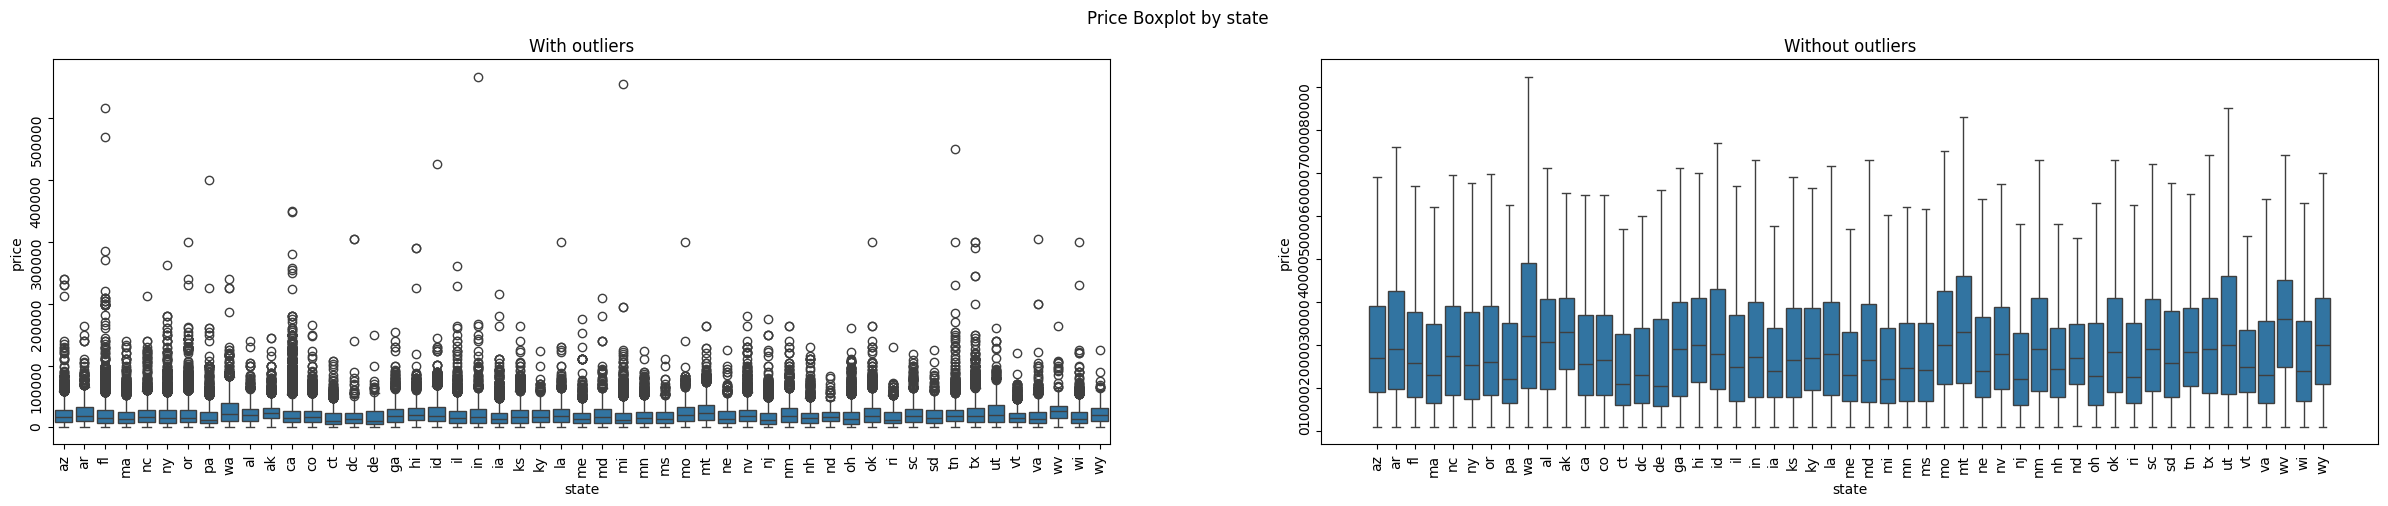

In [25]:
plot_box_price_feature(data1,'state')

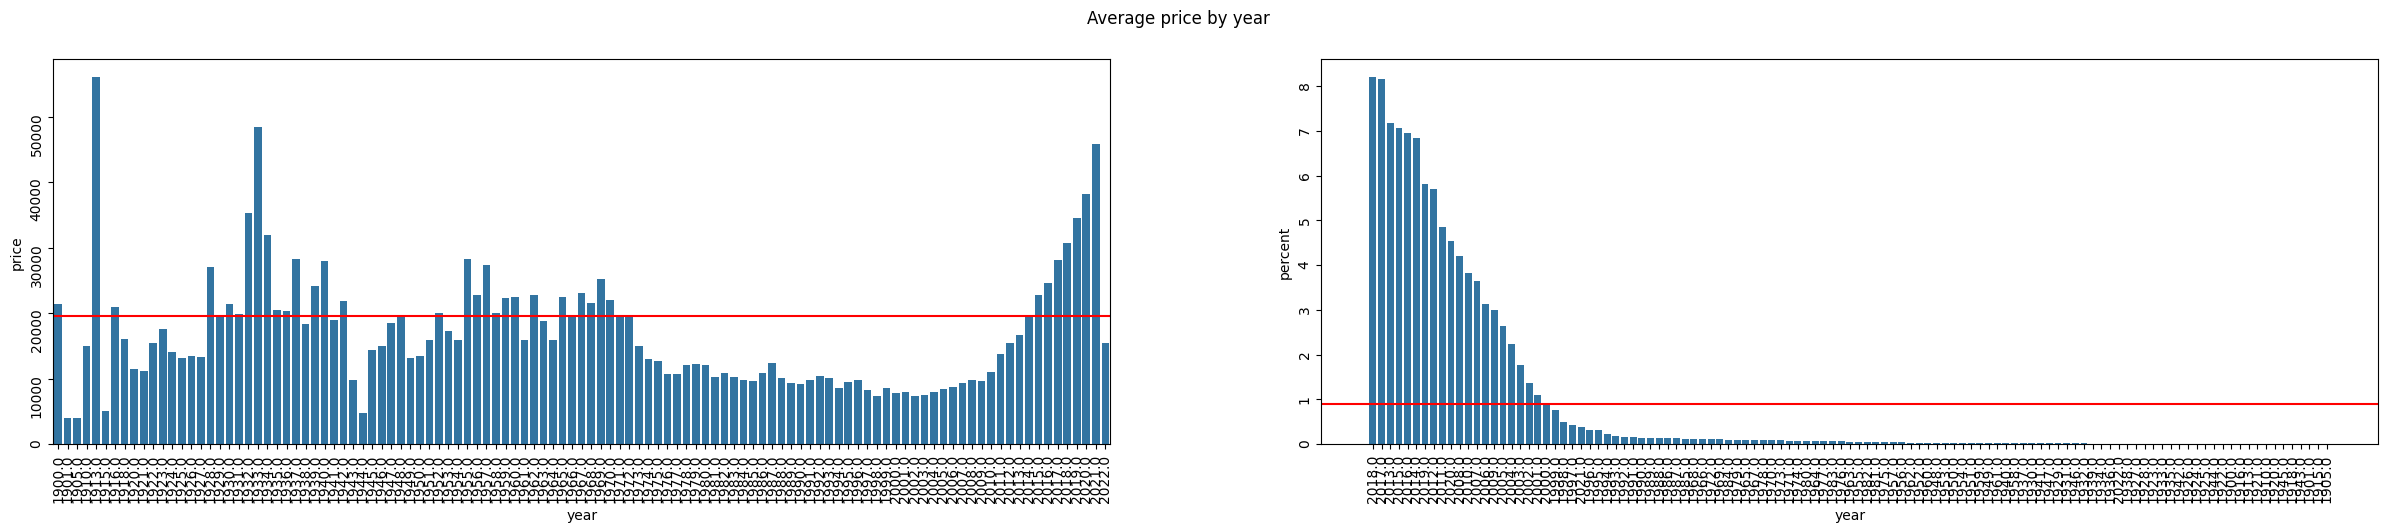

In [26]:
# by year
plot_avg_price_feature(data1,'year')

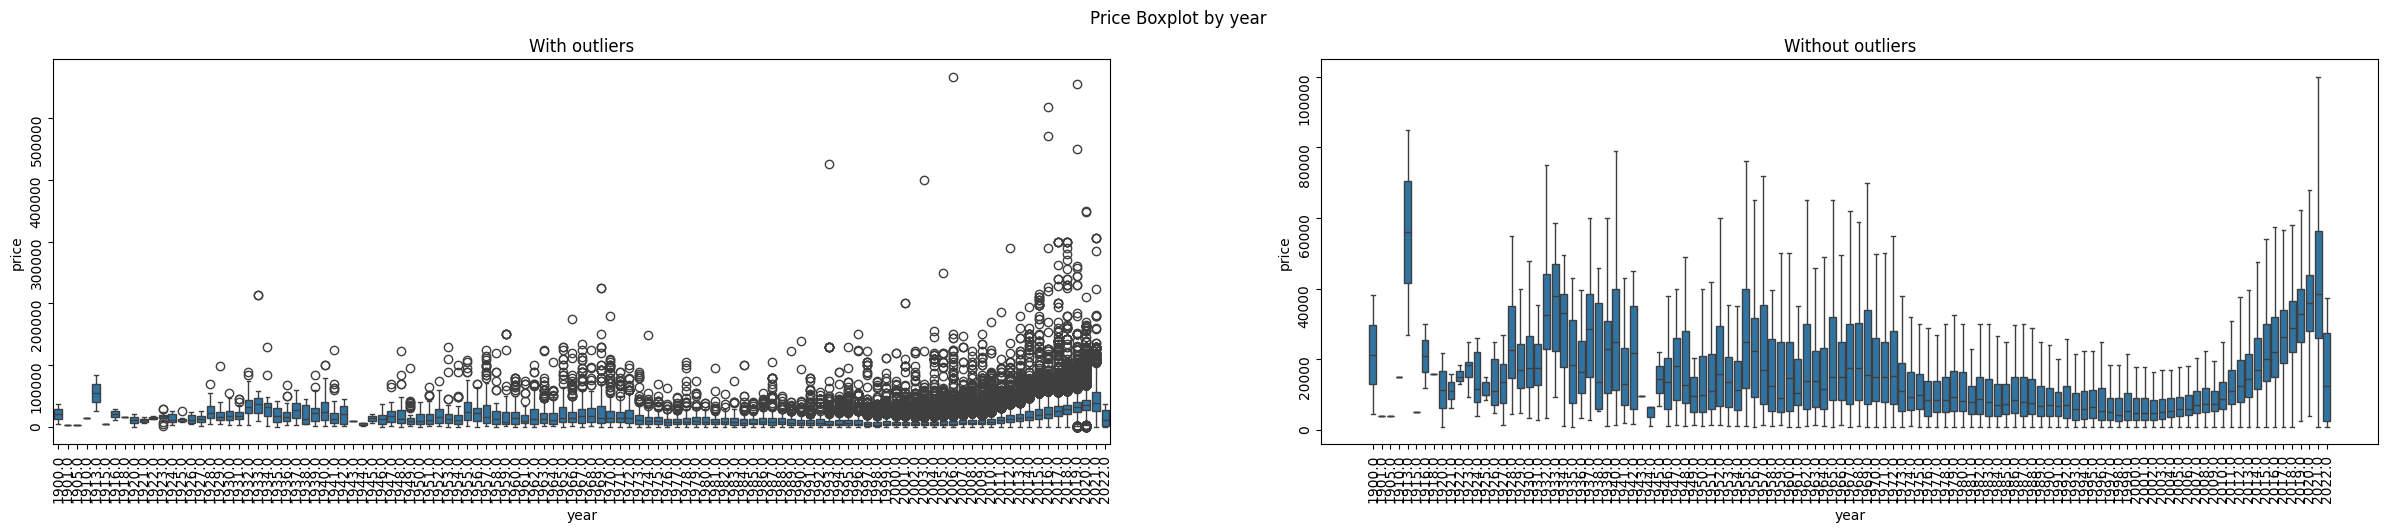

In [27]:
plot_box_price_feature(data1,'year')

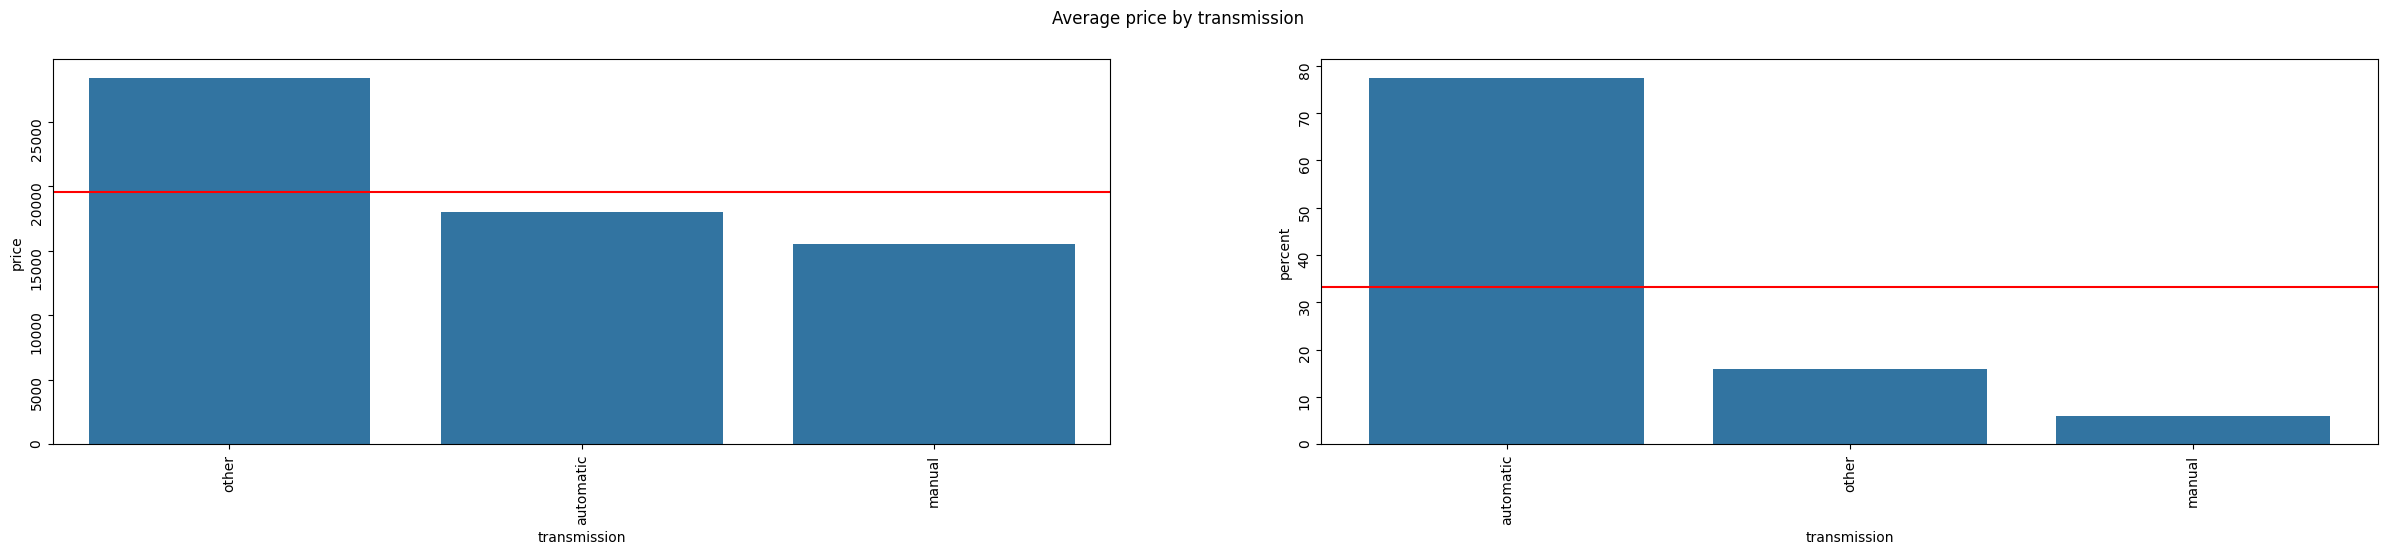

In [28]:
# by transmission
plot_avg_price_feature(data1,'transmission')

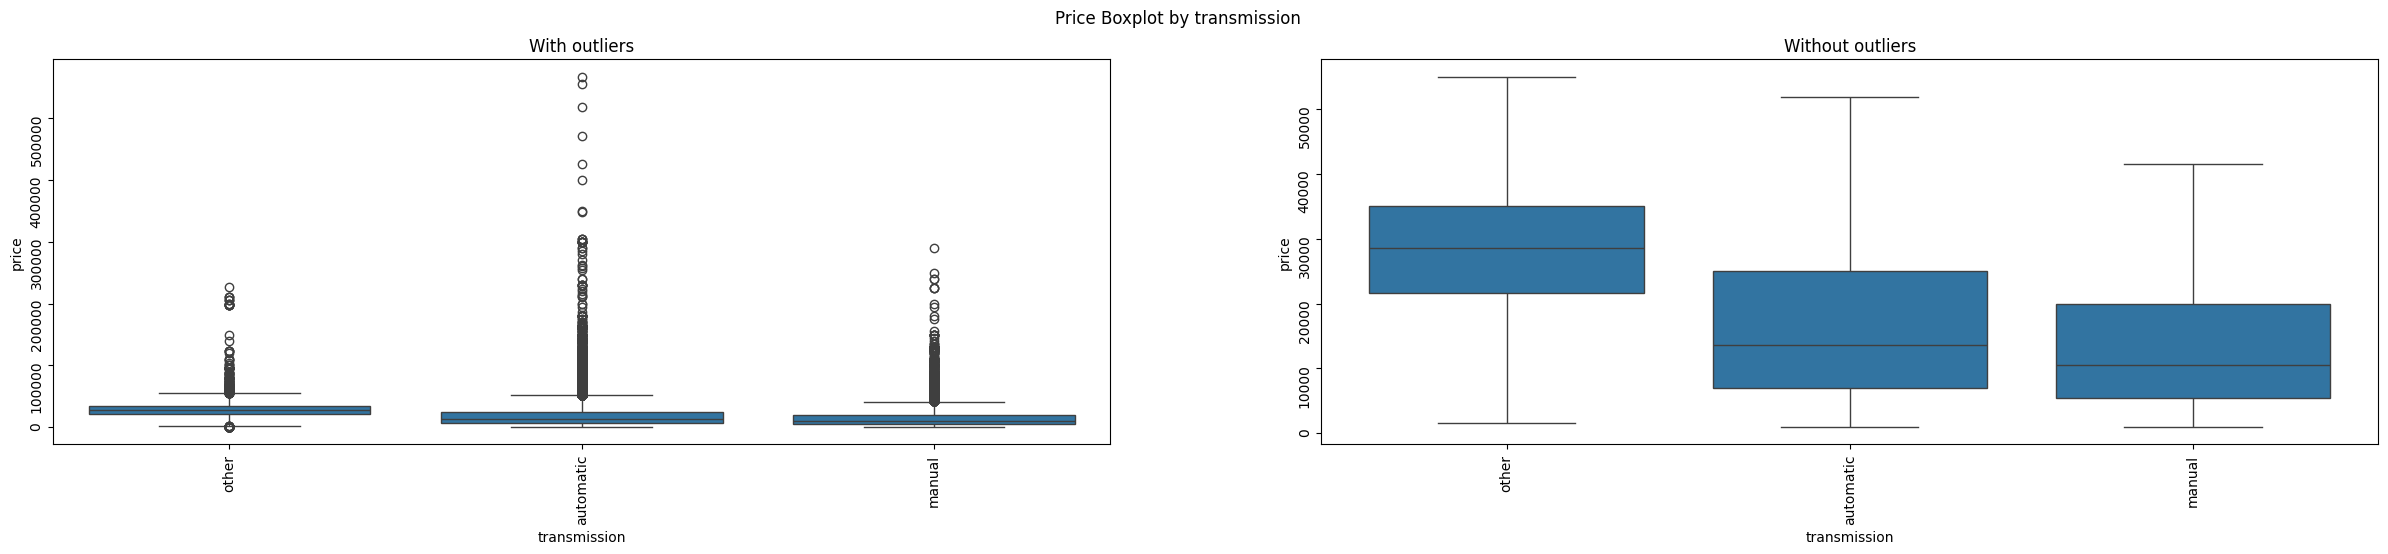

In [29]:
plot_box_price_feature(data1,'transmission')

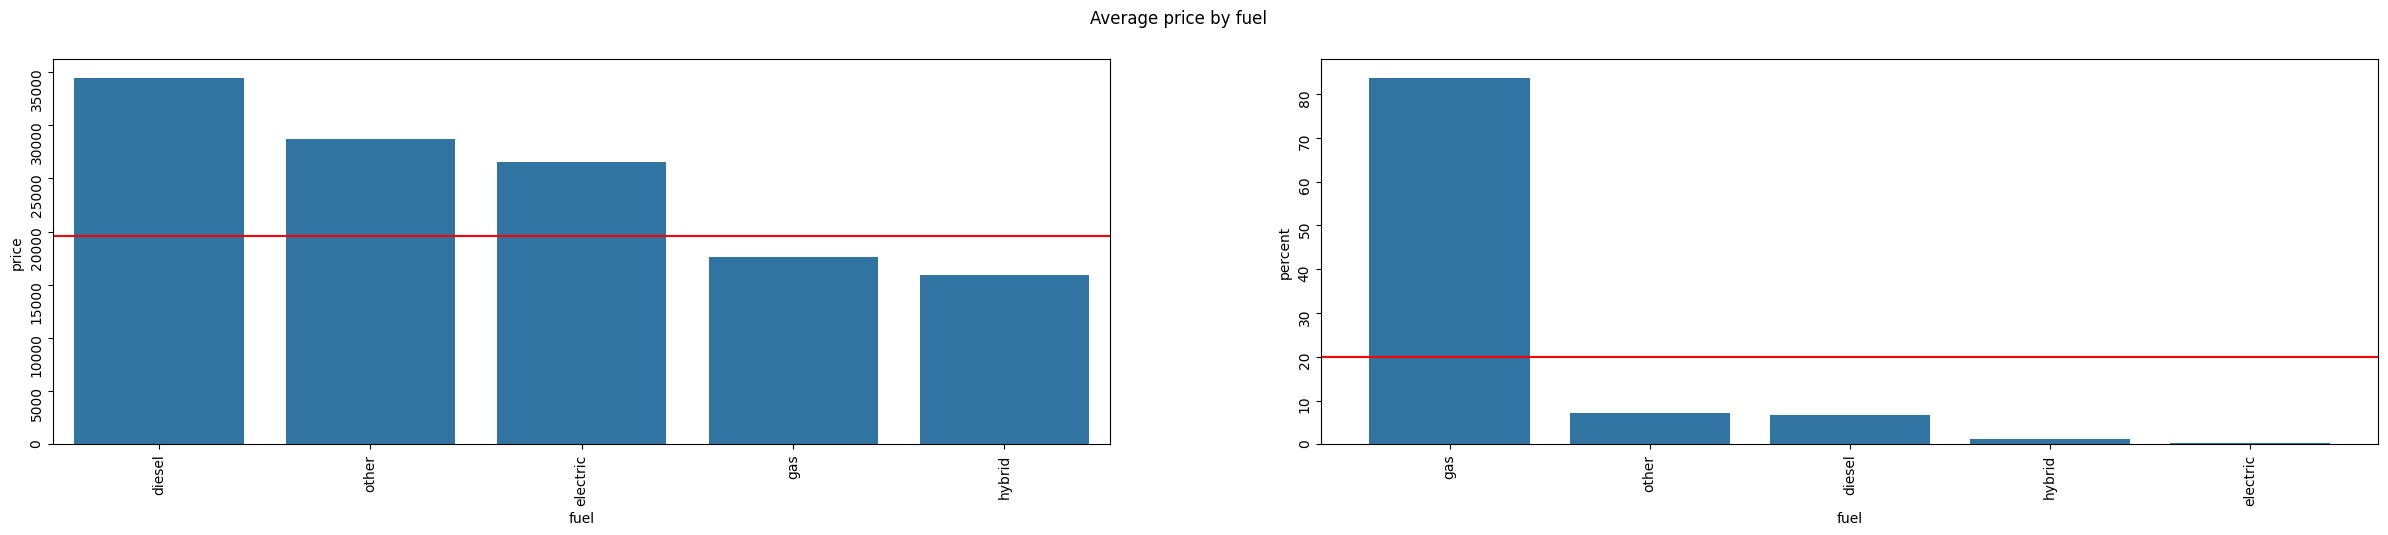

In [30]:
# by fuel
plot_avg_price_feature(data1,'fuel')

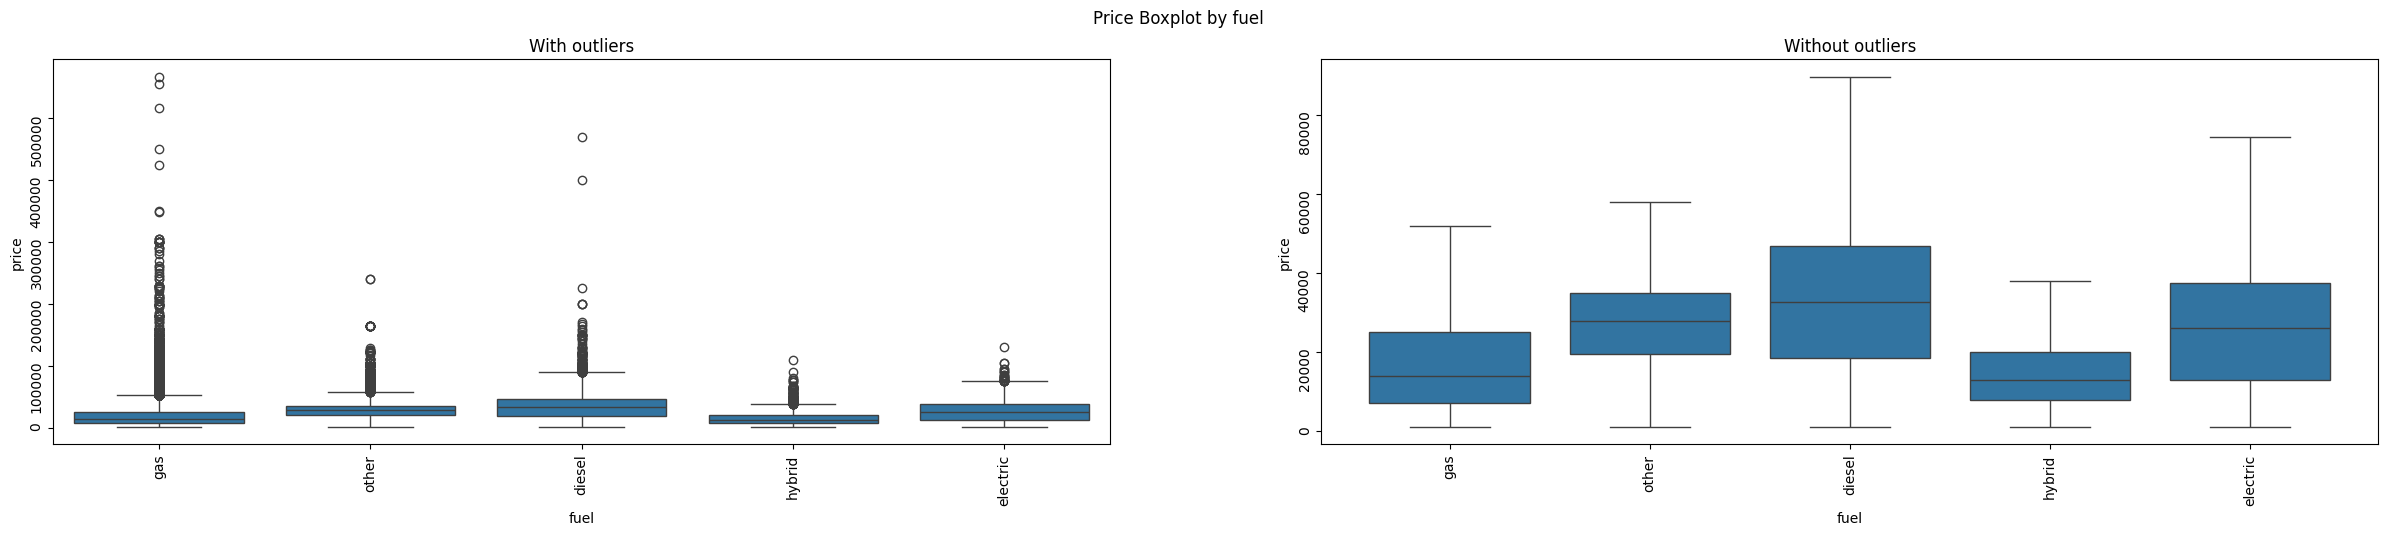

In [31]:
plot_box_price_feature(data1,'fuel')

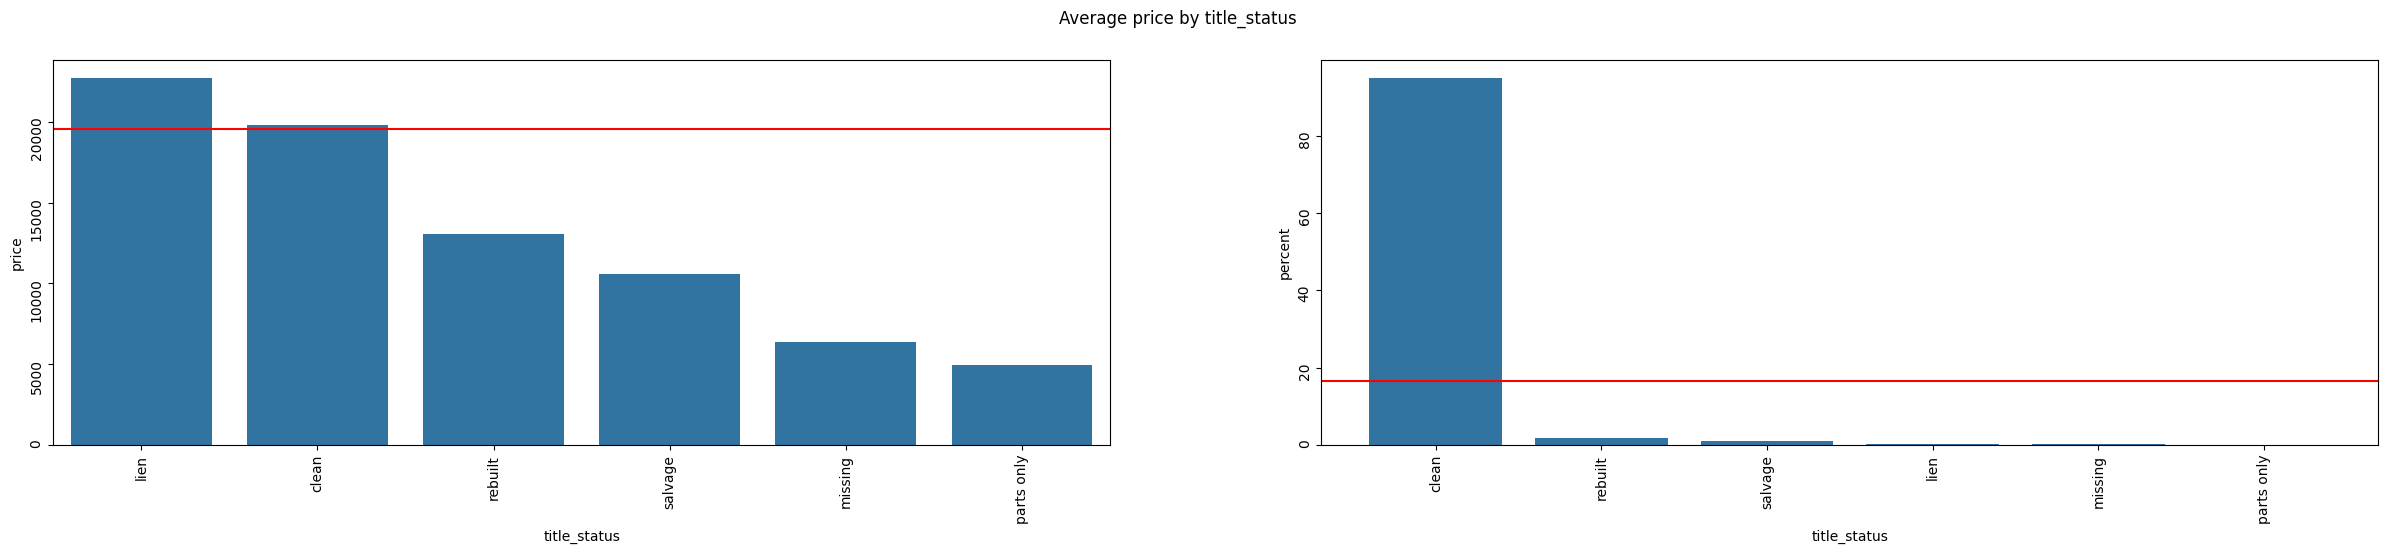

In [32]:
# by title_status
plot_avg_price_feature(data1,'title_status')

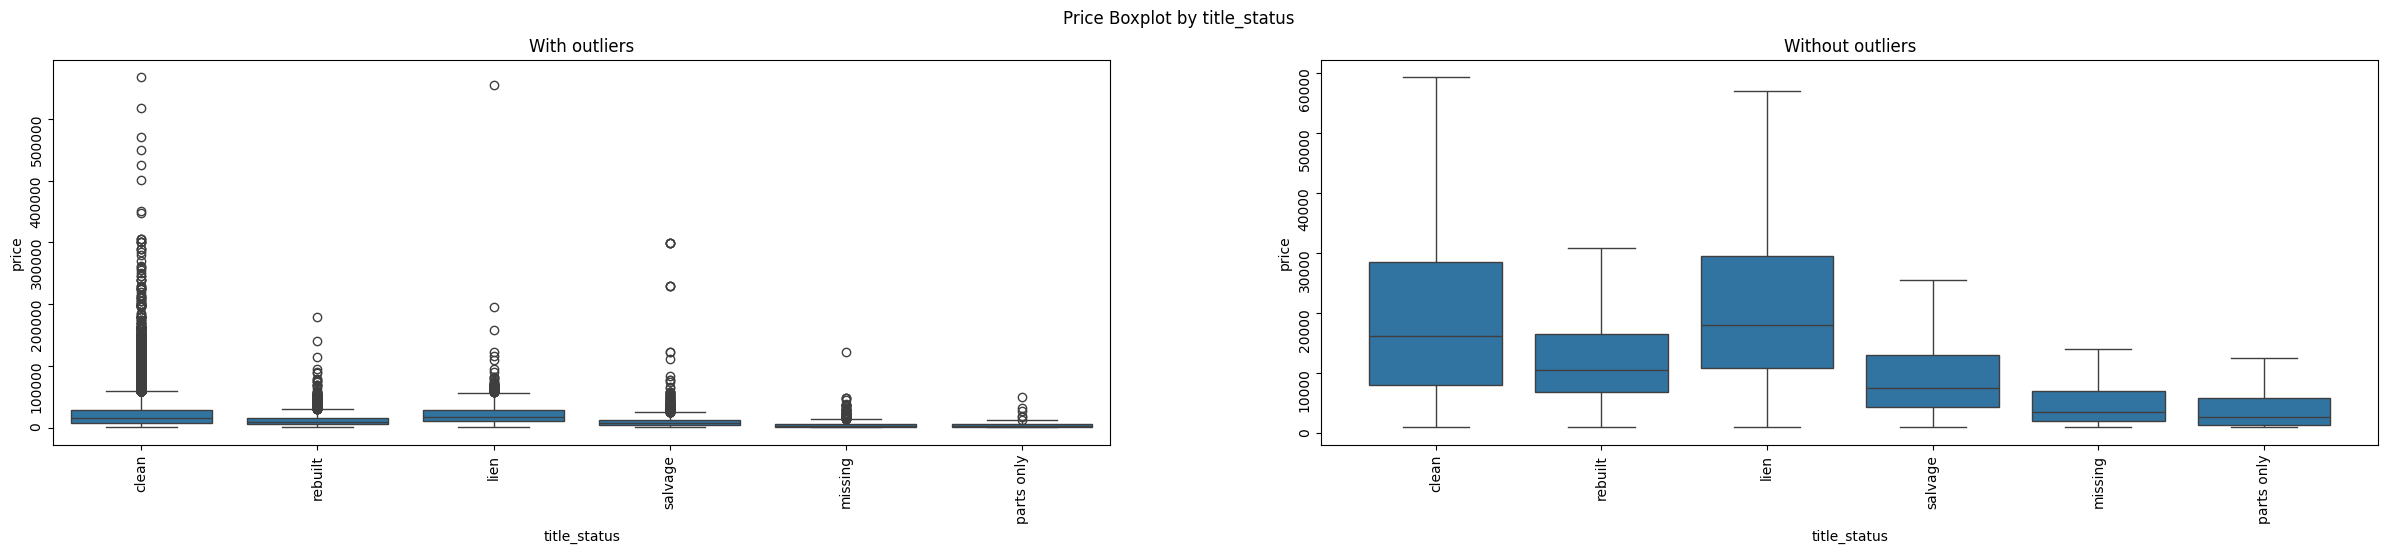

In [33]:
plot_box_price_feature(data1,'title_status')

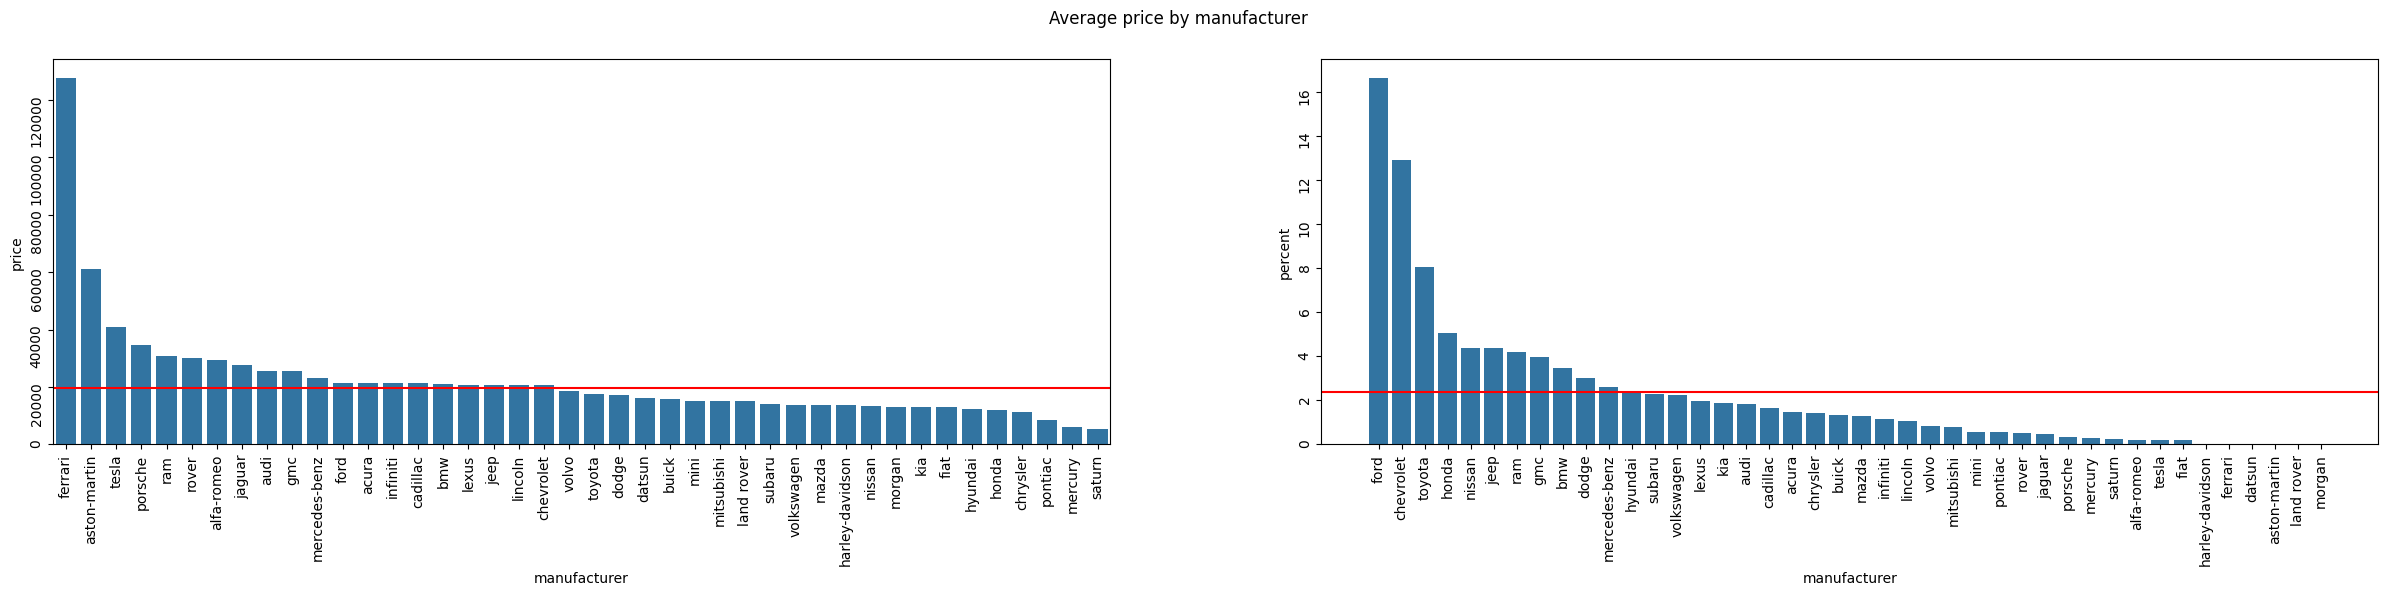

In [34]:
# by manufacturer
plot_avg_price_feature(data1,'manufacturer')

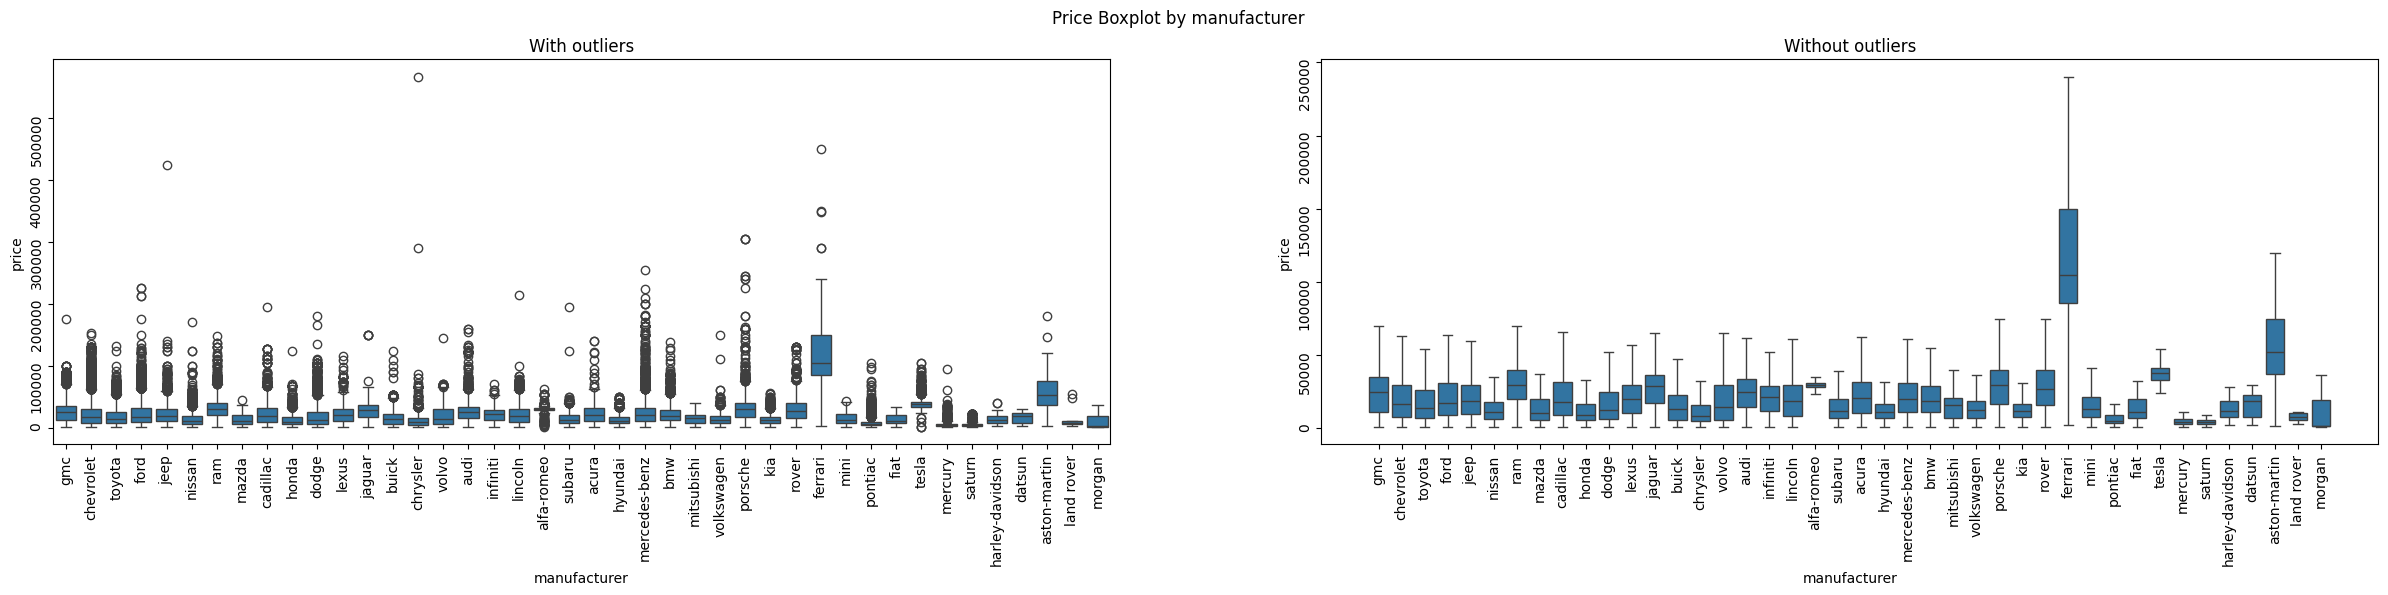

In [35]:
plot_box_price_feature(data1,'manufacturer')

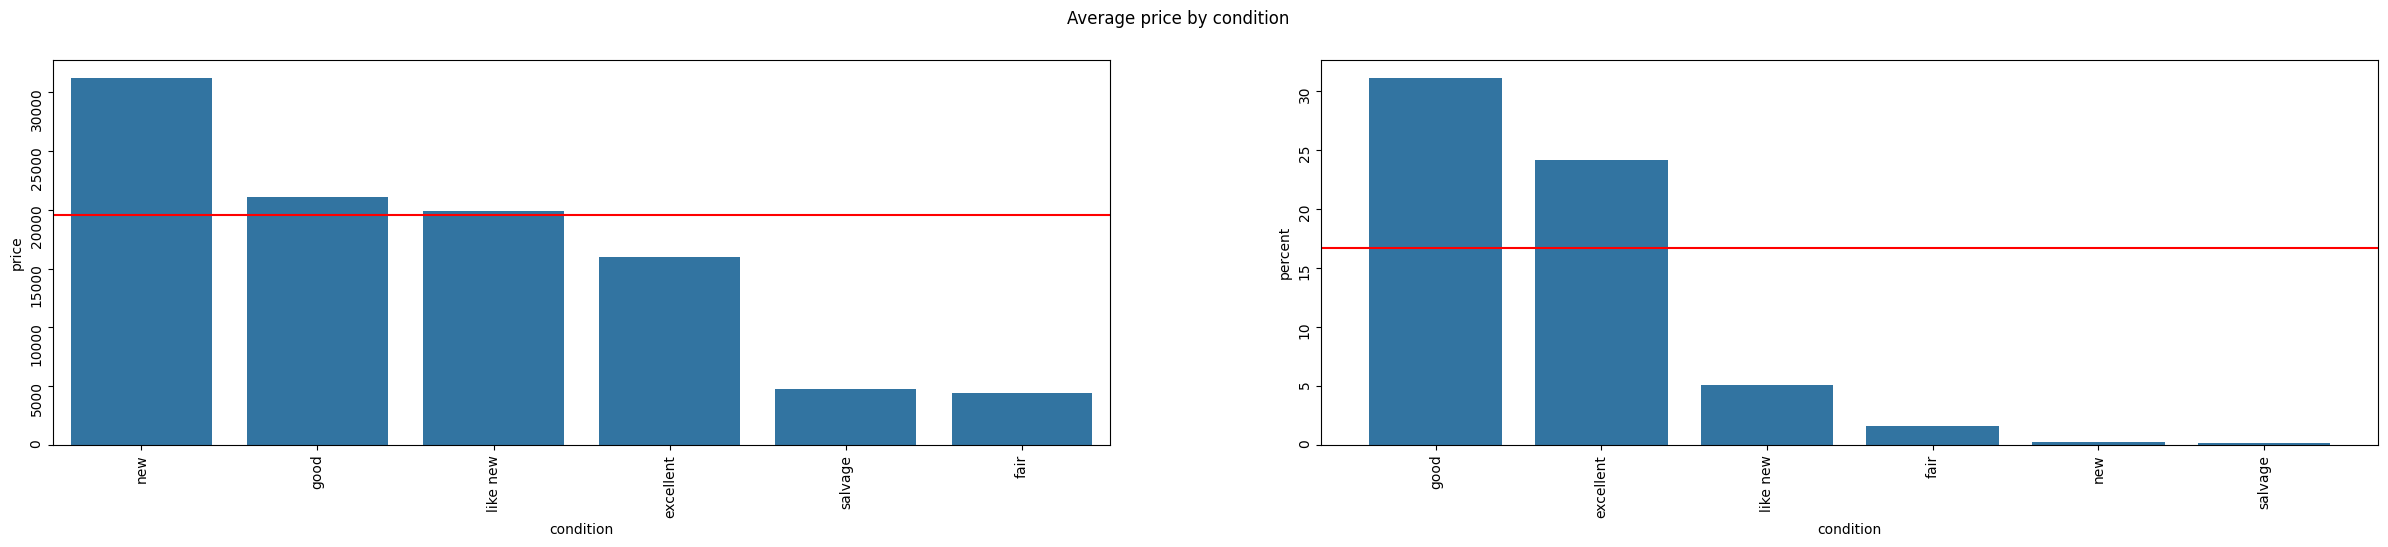

In [36]:
# by manufacturer
plot_avg_price_feature(data1,'condition')

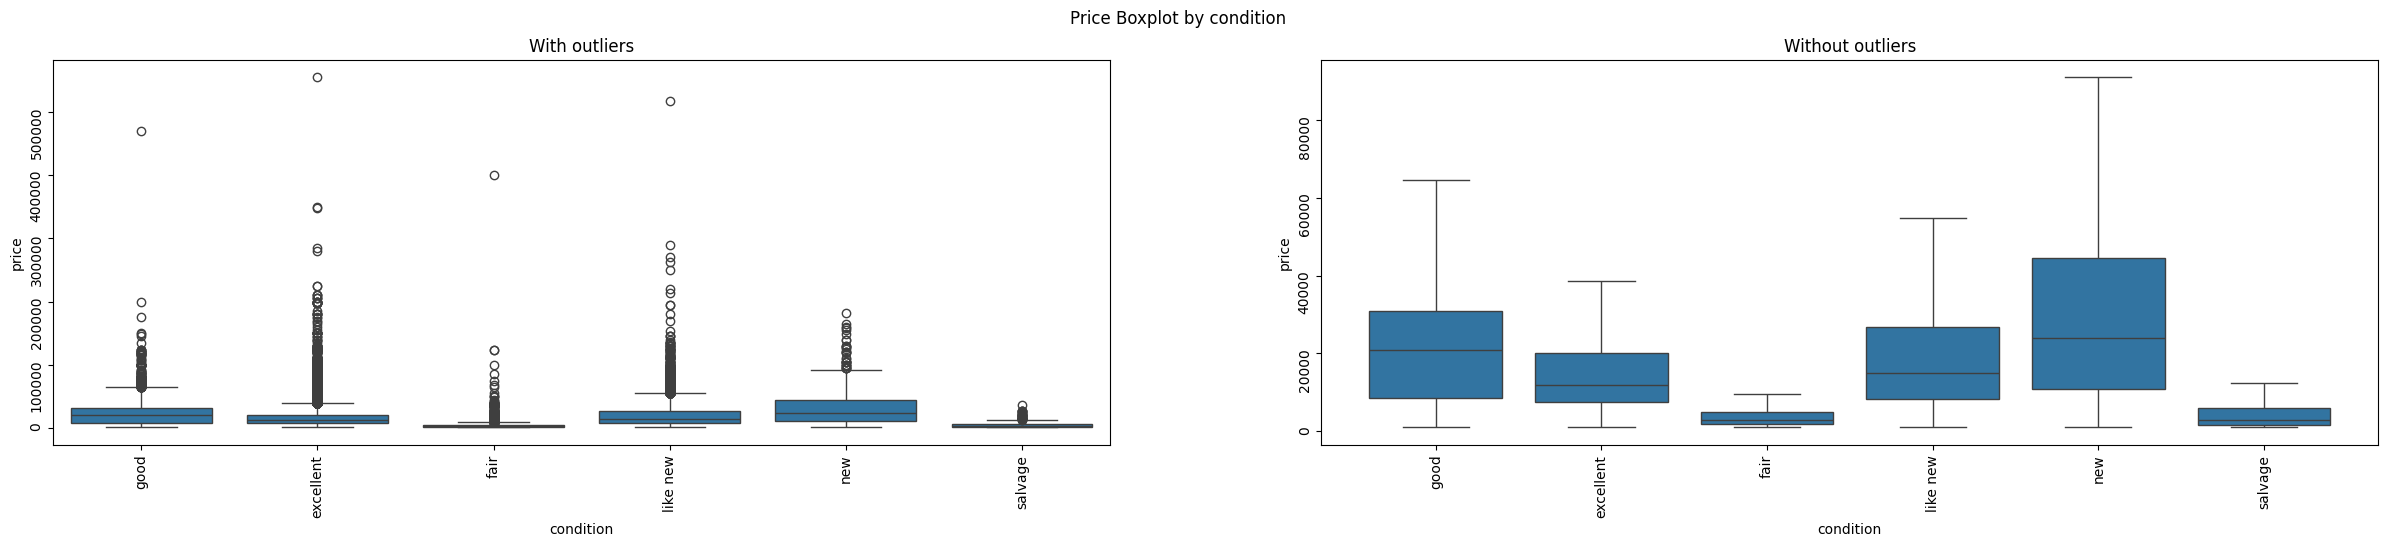

In [37]:
plot_box_price_feature(data1,'condition')

#### Odometer analysis

In [38]:
data[(data['price'] < 600000) & (data['price'] > 999)]['odometer'].describe()

count     378421.000
mean       98146.833
std       184747.792
min            0.000
25%        38177.000
50%        87641.000
75%       136000.000
max     10000000.000
Name: odometer, dtype: float64

[]

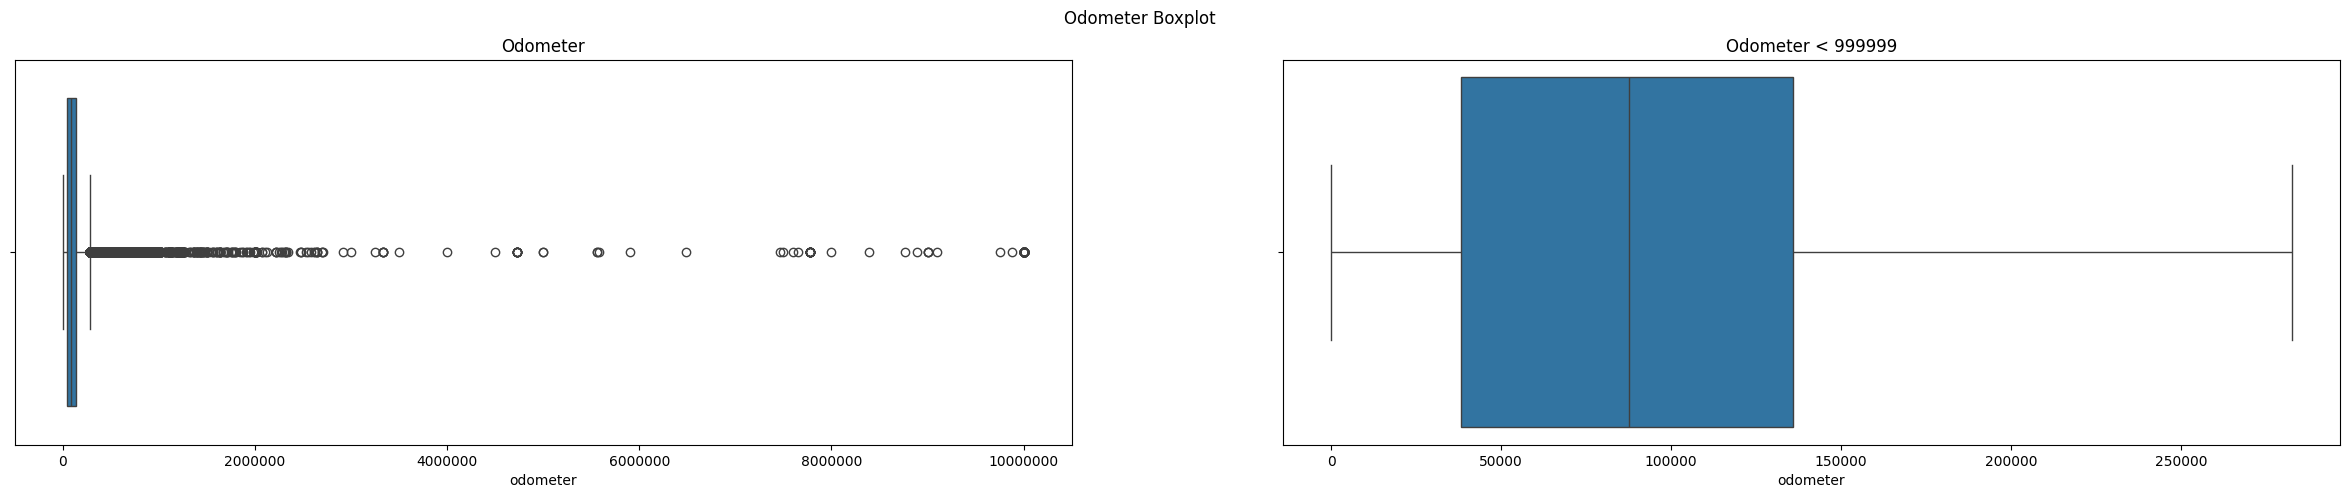

In [39]:
# Boxplot odometer
fig, axes = plt.subplots(1,2,figsize=(30,5))

plt.suptitle(f'Odometer Boxplot')

sns.boxplot(x=data[(data['price'] < 999999) & (data['price'] > 999)]['odometer'],ax=axes[0])
axes[0].set_title('Odometer')
axes[0].ticklabel_format(style='plain', axis='x')

sns.boxplot(x=data[(data['price'] < 999999) & (data['price'] > 999)]['odometer'],ax=axes[1],showfliers = False)
axes[1].set_title('Odometer < 999999')
axes[1].ticklabel_format(style='plain', axis='x')

plt.plot()

### Data Preparation
After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [195]:
# Step 1 - Drop columns
# VIN: Vehicle Unique Identification Number - does not contribute to the model
# id: Unique identifier for each listing - does not contribute to the model
df_final = data.drop(['id','VIN'],axis=1).copy()

In [196]:
# Step 2 - Drop columns
# Drop columns with a large number of missing values
df_final = df_final.drop(['size','cylinders','drive','paint_color','type'],axis=1)

In [197]:
# Step 3 - Drop rows
# Drop rows where price is less than 1000 and price is greater than 600000
drop_price_0 = df_final.query('price < 999 or price >= 600000').shape[0]
print(f'Number of rows that will be dropped because price is equal to or less than 0: {drop_price_0}')
df_final = df_final.drop(df_final.query('price < 999 or price >= 600000').index)

Number of rows that will be dropped because price is equal to or less than 0: 46204


In [198]:
# Step 4 - Drop rows
# Drop rows where odometer is equal to or greater than 999999
# Apparently these values are data entry errors or real outliers which will however make the model less accurate
drop_odometer_999999 = df_final.query('odometer >= 999999').shape[0]
print(f'Number of rows that will be dropped because odometer is equal to or greater than 999999: {drop_odometer_999999}')
df_final = df_final.drop(df_final.query('odometer >= 999999').index)

Number of rows that will be dropped because odometer is equal to or greater than 999999: 668


In [199]:
# Step 5 - Drop rows
# Drop NaN rows for specif columns
# Because they are columns with categorical values, I chose not to use any input method
df_final = df_final.dropna(subset = ['state','manufacturer','model','fuel','title_status','transmission','year'])

In [200]:
print(f'Total number of dropped rows: {data.shape[0]-df_final.shape[0]}')
print(f'Total % of dropped rows: {round((data.shape[0]-df_final.shape[0])/data.shape[0]*100,2)}%')
print(f'% of rows on final DataFrame compared to original DF: {round(df_final.shape[0]/data.shape[0]*100,2)}%')
print(f'DF final shape: {df_final.shape}')

Total number of dropped rows: 75286
Total % of dropped rows: 17.64%
% of rows on final DataFrame compared to original DF: 82.36%
DF final shape: (351594, 11)


In [201]:
(df_final.isna().mean()*100).sort_values()

region          0.000
price           0.000
year            0.000
manufacturer    0.000
model           0.000
fuel            0.000
transmission    0.000
title_status    0.000
state           0.000
odometer        0.497
condition      37.286
dtype: float64

## Split dataset into train, test

In [202]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final[['state','manufacturer','fuel','title_status','transmission','odometer','year','model','condition']], df_final['price'], test_size=0.3, random_state=7)

## Modeling

Regression models with the price as the target

In [203]:
# As 'model' is a very important variable, I created a function to keep the name of the main models and replace the rest with 'other'

# Function to select X% of most frequent models and replace other models with 'other' (Fit)
def model_reducer_fit(df,threshold=0.5):
    # Calculate the frequency of each model
    model_counts = df['model'].value_counts()
    
    # Calculate the cumulative frequency and find models that make up 80% of the data
    top_models = model_counts.cumsum() <= (len(df) * threshold)
    top_models = top_models[top_models].index.tolist()

    return top_models

# Function to transform
def model_reducer_transform(df,top_models):
    # Replace models not in the top with 'other'
    df['model_reduced'] = df['model'].apply(lambda x: x if x in top_models else 'other')
    return df

In [204]:
# Fit the function
# top_models = model_reducer_fit(X_train)

# # # Transform
# X_train = model_reducer_transform(X_train,top_models)
# # X_train.query('model_reduced == "other"')
# X_train.head()

In [205]:
# # Custom ModelReducer Transformer
# from sklearn.base import BaseEstimator, TransformerMixin

# class ModelReducer(BaseEstimator, TransformerMixin):
#     def __init__(self, threshold=0.1):
#         self.threshold = threshold
#         self.top_models = None

#     def fit(self, X, y=None):
#         # Calculate the cumulative frequency
#         model_counts = X['model'].value_counts(normalize=True)
#         top_models = model_counts.cumsum() <= self.threshold
#         self.top_models = top_models[top_models].index.tolist()
#         return self

#     def transform(self, X, y=None):
#         X = X.copy()
#         X['model_reduced'] = X['model'].apply(lambda x: x if x in self.top_models else 'other')
#         return X




# # Create an instance of the ModelReducer
# model_reducer = ModelReducer(threshold=0.1)

# # Fit and transform a subset of your data
# reduced_data = model_reducer.fit_transform(df_final[['model']])

# # Check the output
# print(reduced_data.head())

# # Check the frequency of the transformed 'model' column
# print(reduced_data['model_reduced'].value_counts(normalize=True))


In [206]:
# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

# Initialize the Normalizer
norm = Normalizer()

# Initialize the SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_condition = SimpleImputer(strategy='constant', fill_value='unknown')

# Pipeline for 'condition' column
condition_pipeline = Pipeline([
    ('imp_condition', imp_condition),
    ('ohe_condition', ohe)
])

# Pipeline for 'odometer' column
odometer_pipeline = Pipeline([
    ('imp', imp),
    ('norm', norm)
])

# Pipeline for 'model' column
# model_reducer_pipeline = Pipeline([
#     ('model_reducer', ModelReducer(threshold=0.1)),
#     ('ohe', ohe)
# ])

# ct = ColumnTransformer(transformers=[
#     ('odometer_pipeline',odometer_pipeline,['odometer']),
#     ('condition_pipeline', condition_pipeline, ['condition']),
#     # ('model_reducer_pipeline', model_reducer_pipeline, ['model']),
#     # ('ohe',ohe,['state','manufacturer','fuel','title_status','transmission']),
#     ('ohe',ohe,['state','manufacturer','fuel','title_status','transmission','model_reduced']),
#     ],remainder='drop')

model_reducer_transformer = FunctionTransformer(model_reducer_transform, validate=False)


ct = ColumnTransformer(transformers=[
    ('odometer_pipeline',odometer_pipeline,['odometer']),
    ('condition_pipeline', condition_pipeline, ['condition']),
    ('ohe',ohe,['state','manufacturer','fuel','title_status','transmission','model_reduced']),
    ],remainder='drop')


tt1 = TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp)

#### Model 1 - Linear Regression

In [207]:
# Pipeline for Linear Regression
pipe1 = Pipeline([
    ('colum_transformer',ct),
    ('model', tt1)
])

In [208]:
# Pipeline fit
top_models = model_reducer_fit(X_train,0.8)
pipe1.fit(model_reducer_transform(X_train,top_models), y_train)

Pipeline(steps=[('colum_transformer',
                 ColumnTransformer(transformers=[('odometer_pipeline',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('norm',
                                                                   Normalizer())]),
                                                  ['odometer']),
                                                 ('condition_pipeline',
                                                  Pipeline(steps=[('imp_condition',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe_condition',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['state', 'manufacturer',
                                                   'fuel', 'title_status',
                                                   'transmission',
                                                   'model_reduced'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [209]:
# Predict
y_pred = pipe1.predict(model_reducer_transform(X_test,top_models))

In [210]:
# NaN validation
print(f'y_test: {y_test.isna().sum()}')
print(f'y_pred: {np.isnan(y_pred).sum()}')

# Mean squared error
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# R2
r2 = r2_score(y_test, y_pred)
print('R2: ', round(r2,10))

y_test: 0
y_pred: 0
MSE:  121446228.6681807
R2:  0.4359796716


#### Model 2 - Lasso

In [211]:
tt2 = TransformedTargetRegressor(regressor=Lasso(),func=np.log, inverse_func=np.exp)

In [212]:
# Pipeline for Linear Regression
pipe2 = Pipeline([
    ('ct',ct),
    ('model', tt2)
])

In [213]:
# Define the parameter grid
param_grid = {
    'model__regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe2, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit it to your data
# X_train and y_train should be your training data
grid_search.fit(model_reducer_transform(X_train,top_models), y_train)

# Find the best alpha value
best_alpha = grid_search.best_params_['model__regressor__alpha']
print("Best alpha:", best_alpha)

Best alpha: 0.01


In [214]:
# Get the best estimator
best_pipeline = grid_search.best_estimator_

In [215]:
# Predict
y_pred = best_pipeline.predict(model_reducer_transform(X_test,top_models))

# NaN validation
print(f'y_test: {y_test.isna().sum()}')
print(f'y_pred: {np.isnan(y_pred).sum()}')

y_test: 0
y_pred: 0


In [216]:
# Mean squared error
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# R2
r2 = r2_score(y_test, y_pred)
print('R2: ', round(r2,10))

MSE:  191353153.00765055
R2:  0.1113180756


#### Model 3 - Ridge

In [217]:
tt3 = TransformedTargetRegressor(regressor=Ridge(),func=np.log, inverse_func=np.exp)

In [218]:
# Pipeline for Ridge
pipe3 = Pipeline([
    ('ct',ct),
    ('model', tt3)
])

In [219]:
# Define the parameter grid
param_grid = {
    'model__regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe3, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit it to your data
# X_train and y_train should be your training data
grid_search.fit(model_reducer_transform(X_train,top_models), y_train)

# Find the best alpha value
best_alpha = grid_search.best_params_['model__regressor__alpha']
print("Best alpha:", best_alpha)

Best alpha: 0.01


In [220]:
# Get the best estimator
best_pipeline = grid_search.best_estimator_

In [221]:
# Predict
y_pred = best_pipeline.predict(model_reducer_transform(X_test,top_models))

# NaN validation
print(f'y_test: {y_test.isna().sum()}')
print(f'y_pred: {np.isnan(y_pred).sum()}')

y_test: 0
y_pred: 0


In [222]:
# Mean squared error
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# R2
r2 = r2_score(y_test, y_pred)
print('R2: ', round(r2,10))

MSE:  121384781.26355758
R2:  0.4362650455


In [ ]:

# Group by 'model' and get the most common 'size' for each model
common_size_per_model = data.groupby('model')['size'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_size_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_size_per_model[common_size_per_model.apply(len) > 1]
    print("Models with multiple mode sizes:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode size.")

# # Function to impute size
# def impute_size(row):
#     if pd.isnull(row['size']) and row['model'] in common_size_per_model:
#         return common_size_per_model[row['model']]
#     return row['size']

# # Apply the function to each row
# data['size'] = data.apply(impute_size, axis=1)

In [ ]:
# Group by 'model' and get the most common 'manufacturer' for each model
common_manufacturer_per_model = data.groupby('model')['manufacturer'].agg(lambda x: x.nunique())

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_manufacturer_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_manufacturer_per_model[common_manufacturer_per_model.apply(len) > 1]
    print("Models with multiple mode manufacturers:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode manufacturer.")

In [ ]:
# Group by 'model' and get the most common 'drive' for each model
common_drive_per_model = data.groupby('model')['drive'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_drive_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_drive_per_model[common_drive_per_model.apply(len) > 1]
    print("Models with multiple mode drives:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode drive.")

In [ ]:
# Group by 'model' and get the most common 'type' for each model
common_type_per_model = data.groupby('model')['type'].agg(pd.Series.mode)

# Check if the output is a DataFrame (indicating multiple modes for at least one model)
if isinstance(common_type_per_model, pd.DataFrame):
    # Find models with multiple mode sizes
    models_with_multiple_modes = common_type_per_model[common_type_per_model.apply(len) > 1]
    print("Models with multiple mode types:")
    print(models_with_multiple_modes)
else:
    print("Each model has a single mode type.")

In [ ]:
# Group by 'model' and aggregate unique values for 'size', 'manufacturer', 'drive', and 'type'
unique_values_per_model = data.groupby('model')[['size', 'manufacturer', 'drive', 'type']].agg(lambda x: x.nunique())

# Filter out models that have more than one unique value for any of these attributes
inconsistent_models = unique_values_per_model[(unique_values_per_model > 1).any(axis=1)]

# Print out the inconsistent models
if not inconsistent_models.empty:
    print("Models with inconsistency in size, manufacturer, drive, or type:")
    print(inconsistent_models)
else:
    print("Each model has consistent size, manufacturer, drive, and type.")



In [ ]:
data.query('model == "zephyr"')

In [ ]:
# Assuming 'data' is your DataFrame and it has been loaded already
# Calculate the frequency of each model
model_frequency = data['model'].value_counts(normalize=True)

# Calculate the cumulative sum of the frequencies
model_cumulative_frequency = model_frequency.cumsum()

# Find the number of models needed to reach 80% cumulative frequency
models_needed_for_80_percent = model_cumulative_frequency[model_cumulative_frequency <= 0.80].size

print(models_needed_for_80_percent)

In [ ]:
model_frequency.size